# Initial Exploratory Data Analysis (EDA) for Fraud Detection

This notebook performs an initial EDA on the IEEE-CIS Fraud Detection dataset, focusing on aspects relevant to building both baseline (like XGBoost) and Graph Neural Network (GNN) models.

**Goals:**
1.  Understand basic data characteristics (size, types, missing values).
2.  Analyze the target variable (`isFraud`).
3.  Examine the timestamp feature (`TransactionDT`).
4.  Investigate columns used to create **entity IDs** for a potential heterogeneous graph (e.g., card details, device info, location info).
5.  Analyze the properties (cardinality, selectivity) of the **engineered entity IDs**.
6.  Perform an initial check for **concept drift** in the target and key features.

**Note:** This EDA intentionally *omits* detailed analysis of the anonymized `id_xx` and `Vxxx` columns. Extensive EDA for these features can be found in public Kaggle kernels for the original competition.

## 1. Setup and Configuration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
from tqdm.notebook import tqdm # Use notebook version for better display
import warnings

warnings.filterwarnings('ignore', category=UserWarning) # Suppress common warnings

#  Configuration 
# Adjust path to go up one level from /notebooks to project root
project_root = Path(os.getcwd()).parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
print(f"Project Root: {project_root}")
print(f"Python Path: {sys.path}")

# Attempt to import config from the src directory
try:
    import src.config as config
    print("Successfully imported src.config")
except ModuleNotFoundError as e:
    print(f"Error importing src.config: {e}. Make sure config.py exists in the 'src' directory.")
    # Define essential variables manually if config fails (adjust paths/names)
    config = type('obj', (object,), {
        'RAW_DATA_DIR': os.path.join(project_root, "data", "raw"),
        'TRANSACTION_FILE_TRAIN': os.path.join(project_root, "data", "raw", "train_transaction.csv"),
        'IDENTITY_FILE_TRAIN': os.path.join(project_root, "data", "raw", "train_identity.csv"),
        'ID_COL': 'TransactionID',
        'TARGET_COL': 'isFraud',
        'TIMESTAMP_COL': 'TransactionDT',
        # Define columns used to CREATE entity IDs
        'CARD_ID_COLS': ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'D1'],
        'DEVICE_ID_COLS': ['DeviceType', 'DeviceInfo', 'id_30', 'id_31', 'id_32', 'id_33'],
        'NETWORK_ID_COLS': ['id_17', 'id_19', 'id_20'],
        'LOCALITY_ID_COLS': ['addr1', 'addr2'],
        # Define the names of the FINAL entity ID columns
        'ENTITY_ID_NAMES': ['card_id', 'device_profile_id', 'network_profile_id', 'locality_id'],
        # Key features for drift analysis
        'KEY_NUM_FEATURES': ['TransactionAmt', 'C1', 'D1', 'D15', 'card1'], # Added card1
        'KEY_CAT_FEATURES': ['ProductCD', 'card4', 'M4', 'DeviceType', 'addr1'] # Added DeviceType, addr1
    })()
    print("Using manually defined config variables.")

#  Plotting Style 
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
tqdm.pandas() # Enable progress bars for pandas apply

#  Parameters 
# Set to None to load all data (requires significant RAM & time)
N_ROWS_TO_LOAD = 150000 # Load a larger subset for better analysis, None for full dataset
N_TIME_BINS = 10 # How many time periods to divide the data into

Project Root: /Users/aca/UoL/final/fdgnn
Python Path: ['/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/aca/UoL/final/fdgnn/.venv/lib/python3.11/site-packages', '/Users/aca/UoL/final/fdgnn']
Successfully imported src.config


## 2. Data Loading and Basic Information

In [4]:
def load_and_merge(trans_path, id_path, id_col, nrows=None):
    """Loads and merges transaction and identity data."""
    print(f"Loading data... (nrows={nrows})")
    try:
        print(f"  Loading transactions: {trans_path}")
        df_trans = pd.read_csv(trans_path, nrows=nrows, low_memory=False)
        print(f"  Loading identity: {id_path}")
        # Only load corresponding IDs if sampling transactions
        if nrows is not None:
            trans_ids = df_trans[id_col].unique()
            df_id = pd.read_csv(id_path, low_memory=False)
            df_id = df_id[df_id[id_col].isin(trans_ids)]
        else:
            df_id = pd.read_csv(id_path, low_memory=False)

        print(f"  Merging data on '{id_col}'...")
        df = pd.merge(df_trans, df_id, on=id_col, how='left')
        print(f"Data loaded and merged. Shape: {df.shape}")
        mem_usage = df.memory_usage(index=True).sum()
        print(f"Memory usage: {mem_usage / 1024**2:.2f} MB")
        return df
    except FileNotFoundError as e:
        print(f"Error loading data: {e}. Make sure files exist at specified paths.")
        raise
    except Exception as e:
        print(f"An unexpected error occurred during loading: {e}")
        raise

# Load the data
df = load_and_merge(
    config.TRANSACTION_FILE_TRAIN,
    config.IDENTITY_FILE_TRAIN,
    config.ID_COL,
    nrows=N_ROWS_TO_LOAD
)

Loading data... (nrows=150000)
  Loading transactions: /Users/aca/UoL/final/fdgnn/data/raw/train_transaction.csv
  Loading identity: /Users/aca/UoL/final/fdgnn/data/raw/train_identity.csv
  Merging data on 'TransactionID'...
Data loaded and merged. Shape: (150000, 434)
Memory usage: 496.67 MB


In [5]:
print("DataFrame Info:")
df.info(verbose=True, show_counts=True)

print("\nBasic Numerical Statistics:")
# Include more percentiles for skewed data like TransactionAmt
print(df.describe(percentiles=[.01, .1, .25, .5, .75, .9, .99]).transpose())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 434 columns):
 #    Column          Non-Null Count   Dtype  
---   ------          --------------   -----  
 0    TransactionID   150000 non-null  int64  
 1    isFraud         150000 non-null  int64  
 2    TransactionDT   150000 non-null  int64  
 3    TransactionAmt  150000 non-null  float64
 4    ProductCD       150000 non-null  object 
 5    card1           150000 non-null  int64  
 6    card2           147966 non-null  float64
 7    card3           149997 non-null  float64
 8    card4           149992 non-null  object 
 9    card5           149209 non-null  float64
 10   card6           149993 non-null  object 
 11   addr1           133882 non-null  float64
 12   addr2           133882 non-null  float64
 13   dist1           47242 non-null   float64
 14   dist2           12714 non-null   float64
 15   P_emaildomain   127127 non-null  object 
 16   R_emaildomain   5476

## 3. Target Variable Analysis (`isFraud`)

Target variable: 'isFraud'
Value Counts:
isFraud
0    146030
1      3970
Name: count, dtype: int64

Proportions:
isFraud
0    97.353333
1     2.646667
Name: proportion, dtype: float64


/var/folders/rn/k6s2gcss3_v46pqtyf9ds5sh0000gn/T/ipykernel_98931/3360857148.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target, data=df, palette='viridis')


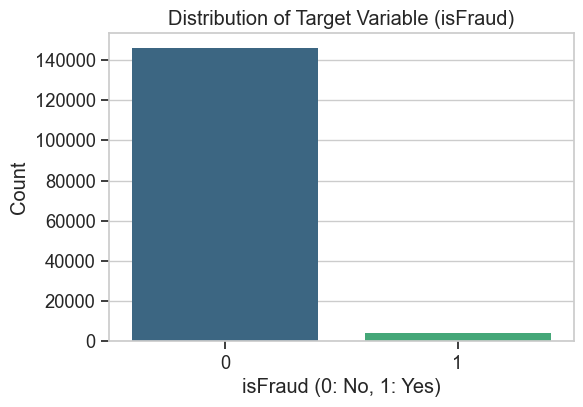

In [6]:
target = config.TARGET_COL
if target in df.columns:
    print(f"Target variable: '{target}'")
    print("Value Counts:")
    print(df[target].value_counts())
    print("\nProportions:")
    print(df[target].value_counts(normalize=True) * 100)

    # Plot distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x=target, data=df, palette='viridis')
    plt.title('Distribution of Target Variable (isFraud)')
    plt.xlabel('isFraud (0: No, 1: Yes)')
    plt.ylabel('Count')
    plt.show()
else:
    print(f"Target column '{target}' not found!")

**Interpretation:** The dataset is highly imbalanced, with a small percentage of fraudulent transactions. This needs to be considered during modeling (e.g., using appropriate metrics like AUC/AP, class weighting, or sampling techniques).

## 4. Timestamp Analysis (`TransactionDT`)

Analyzing timestamp column: 'TransactionDT'


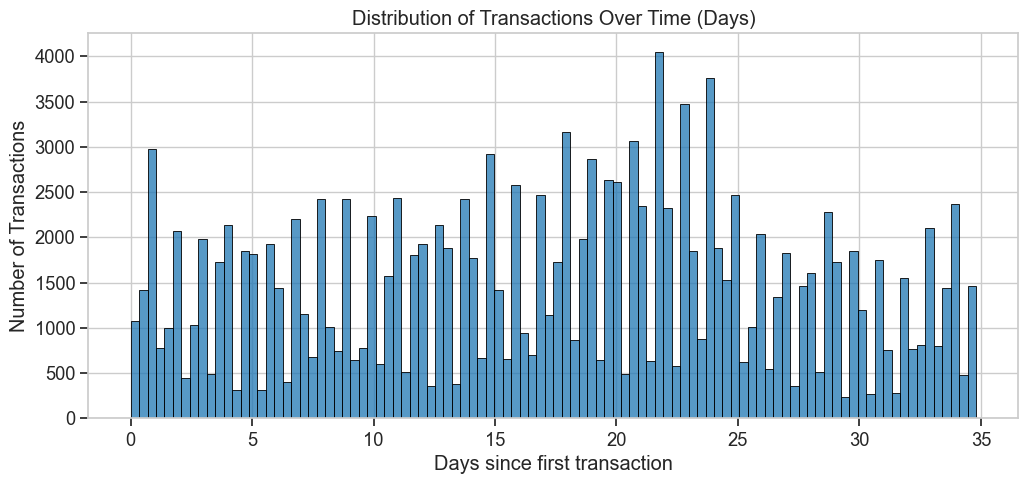

Time range spans approximately 34.8 days.

Created 10 time bins based on 'TransactionDays'.
Time Bin Distribution (Equal Frequency Attempt):
TimeBin
0    15000
1    15000
2    15000
3    15000
4    15000
5    15000
6    15000
7    15000
8    15000
9    15000
Name: count, dtype: int64


In [7]:
ts_col = config.TIMESTAMP_COL
if ts_col in df.columns:
    print(f"Analyzing timestamp column: '{ts_col}'")
    # Convert to days for easier interpretation
    min_dt = df[ts_col].min()
    df['TransactionDays'] = (df[ts_col] - min_dt) / (3600 * 24)

    plt.figure(figsize=(12, 5))
    sns.histplot(df['TransactionDays'], bins=100, kde=False)
    plt.title('Distribution of Transactions Over Time (Days)')
    plt.xlabel('Days since first transaction')
    plt.ylabel('Number of Transactions')
    plt.show()

    print(f"Time range spans approximately {df['TransactionDays'].max():.1f} days.")

    # Create time bins for drift analysis later
    try:
        df['TimeBin'] = pd.qcut(df['TransactionDays'], q=N_TIME_BINS, labels=False, duplicates='drop')
        print(f"\nCreated {df['TimeBin'].nunique()} time bins based on 'TransactionDays'.")
        print("Time Bin Distribution (Equal Frequency Attempt):")
        print(df['TimeBin'].value_counts().sort_index())
    except Exception as e:
        print(f"Error creating time bins: {e}. Check N_TIME_BINS and TransactionDays distribution.")
else:
    print(f"Timestamp column '{ts_col}' not found.")

**Interpretation:** The histogram shows the volume of transactions over the time period covered by the loaded data. Note any significant gaps or periods of unusually high/low activity. The creation of `TimeBin` allows us to analyze drift in subsequent steps.

## 5. Analysis of Entity ID Source Columns

We examine the raw columns that will be used to engineer the entity IDs for the heterogeneous graph. We focus on missing values and cardinality.

In [8]:
# Combine all source columns for entity IDs
entity_source_cols = []
if hasattr(config, 'CARD_ID_COLS'): entity_source_cols.extend(config.CARD_ID_COLS)
if hasattr(config, 'DEVICE_ID_COLS'): entity_source_cols.extend(config.DEVICE_ID_COLS)
if hasattr(config, 'NETWORK_ID_COLS'): entity_source_cols.extend(config.NETWORK_ID_COLS)
if hasattr(config, 'LOCALITY_ID_COLS'): entity_source_cols.extend(config.LOCALITY_ID_COLS)

# Ensure unique columns and that they exist in the dataframe
entity_source_cols = sorted(list(set(entity_source_cols)))
entity_source_cols_present = [col for col in entity_source_cols if col in df.columns]

print(f"Analyzing {len(entity_source_cols_present)} source columns for Entity IDs:")
print(entity_source_cols_present)

# Calculate Missing Values and Cardinality
analysis_results = []
for col in tqdm(entity_source_cols_present, desc="Analyzing Source Columns"):
    missing_pct = df[col].isnull().mean() * 100
    cardinality = df[col].nunique()
    dtype = df[col].dtype
    analysis_results.append({
        'Column': col,
        'DataType': dtype,
        'Missing (%)': f"{missing_pct:.2f}%",
        'Cardinality': cardinality
    })

analysis_df = pd.DataFrame(analysis_results)
print("\nAnalysis of Entity ID Source Columns:")
print(analysis_df.to_string())

Analyzing 17 source columns for Entity IDs:
['D1', 'DeviceInfo', 'DeviceType', 'TransactionDT', 'addr1', 'addr2', 'card1', 'card2', 'card5', 'card6', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33']


Analyzing Source Columns:   0%|          | 0/17 [00:00<?, ?it/s]


Analysis of Entity ID Source Columns:
           Column DataType Missing (%)  Cardinality
0              D1  float64       0.00%          615
1      DeviceInfo   object      64.21%         1095
2      DeviceType   object      60.10%            2
3   TransactionDT    int64       0.00%       144298
4           addr1  float64      10.75%          267
5           addr2  float64      10.75%           50
6           card1    int64       0.00%         8948
7           card2  float64       1.36%          499
8           card5  float64       0.53%           93
9           card6   object       0.00%            4
10          id_17  float64      60.41%           86
11          id_19  float64      60.42%          464
12          id_20  float64      60.43%          274
13          id_30   object      71.38%           67
14          id_31   object      60.14%           85
15          id_32  float64      71.37%            4
16          id_33   object      73.45%          149


**Interpretation:**
*   **Missing Values:** Note columns with high percentages of missing values (e.g., `addr2`, `dist2`, many `id_xx`). This will directly impact the quality and completeness of the engineered entity IDs. The ID creation logic might need robust handling for NaNs (as implemented in the provided `create_entity_ids` example).
*   **Cardinality:** Observe the number of unique values. High cardinality in columns like `card1`, `DeviceInfo`, `addr1` is expected and necessary for creating distinct entity nodes. Very low cardinality columns might not be useful for defining distinct entities.
*   **Data Types:** Check if types are appropriate (mostly objects/strings or numerical for cards/addresses).

## 6. Analysis of Engineered Entity IDs

Here, we simulate the creation of the combined entity IDs (as done in `preprocess_utils.py`) and analyze their properties, particularly their cardinality and how well they group transactions (selectivity).

In [ ]:
#  Simulate Entity ID Creation (using logic from preprocess_utils) 
# Re-implement or import the functions if possible
def create_device_profile_id_eda(row):
    cols = config.DEVICE_ID_COLS
    values = [str(row[c]) if pd.notnull(row[c]) else 'nan' for c in cols if c in row]
    # Adjust threshold based on available columns
    if values.count('nan') >= max(1, len(values) - 1): # Allow at least one non-nan usually
        return 'missing_device'
    else:
        return '_'.join(values)

def create_network_profile_id_eda(row):
    cols = config.NETWORK_ID_COLS
    values = [str(row[c]) if pd.notnull(row[c]) else 'nan' for c in cols if c in row]
    if values.count('nan') >= max(1, len(values) - 1):
        return 'missing_network'
    else:
        return '_'.join(values)

def create_locality_id_eda(row):
    cols = config.LOCALITY_ID_COLS
    values = [str(row[c]) if pd.notnull(row[c]) else 'nan' for c in cols if c in row]
    if values.count('nan') >= len(values): # Only if all are nan
        return 'missing_locality'
    else:
        return '_'.join(values)

def create_card_id_eda(row):
    # Use cols defined in config, check existence
    cols = [c for c in config.CARD_ID_COLS if c in row and c != 'D1']
    # Handle D1 separately for calculation
    d1_val = -9999 # Default if D1 or timestamp missing
    if config.TIMESTAMP_COL in row and 'D1' in row and pd.notnull(row['D1']):
        transaction_day = row[config.TIMESTAMP_COL] / (3600 * 24)
        d1n = row['D1'] - transaction_day
        # Check if d1n is NaN after calculation
        if pd.notnull(d1n):
             d1_val = int(d1n)

    values = [str(row[c]) if pd.notnull(row[c]) else 'nan' for c in cols] + [str(d1_val)]
    return '_'.join(values)

# Apply the functions to create the columns in the loaded dataframe
print("Simulating Entity ID creation...")
df_eda = df.copy() # Work on a copy

# Check which entity IDs can be created based on config
entity_creation_map = {
    'card_id': (create_card_id_eda, config.CARD_ID_COLS),
    'device_profile_id': (create_device_profile_id_eda, config.DEVICE_ID_COLS),
    'network_profile_id': (create_network_profile_id_eda, config.NETWORK_ID_COLS),
    'locality_id': (create_locality_id_eda, config.LOCALITY_ID_COLS)
}

created_entity_ids = []
for entity_name, (func, source_cols) in entity_creation_map.items():
    # Check if all source columns exist
    if all(col in df_eda.columns for col in source_cols):
        print(f"  Creating '{entity_name}'...")
        df_eda[entity_name] = df_eda.progress_apply(func, axis=1)
        created_entity_ids.append(entity_name)
    else:
        missing_src = [col for col in source_cols if col not in df_eda.columns]
        print(f"  Skipping '{entity_name}' creation, missing source columns: {missing_src}")

print("\nAnalysis of Engineered Entity IDs:")
entity_analysis = []
for col in created_entity_ids:
    cardinality = df_eda[col].nunique()
    missing_pct = df_eda[col].isin(['missing_device', 'missing_network', 'missing_locality']).mean() * 100 # Check for specific missing markers
    # Calculate average group size (selectivity)
    avg_group_size = df_eda.groupby(col).size().mean() if cardinality > 0 else 0
    entity_analysis.append({
        'Entity ID': col,
        'Cardinality': cardinality,
        'Missing (%)': f"{missing_pct:.2f}%", # Based on marker
        'Avg Group Size': f"{avg_group_size:.2f}"
    })

entity_analysis_df = pd.DataFrame(entity_analysis)
print(entity_analysis_df.to_string())

Simulating Entity ID creation...
  Creating 'card_id'...


  0%|          | 0/150000 [00:00<?, ?it/s]

  Creating 'device_profile_id'...


  0%|          | 0/150000 [00:00<?, ?it/s]

  Creating 'network_profile_id'...


  0%|          | 0/150000 [00:00<?, ?it/s]

  Creating 'locality_id'...


  0%|          | 0/150000 [00:00<?, ?it/s]


Analysis of Engineered Entity IDs:
            Entity ID  Cardinality Missing (%) Avg Group Size
0             card_id       149997       0.00%           1.00
1   device_profile_id         4450      60.10%          33.71
2  network_profile_id         1829      60.41%          82.01
3         locality_id          310      10.75%         483.87



Analyzing 'card_id' Selectivity...


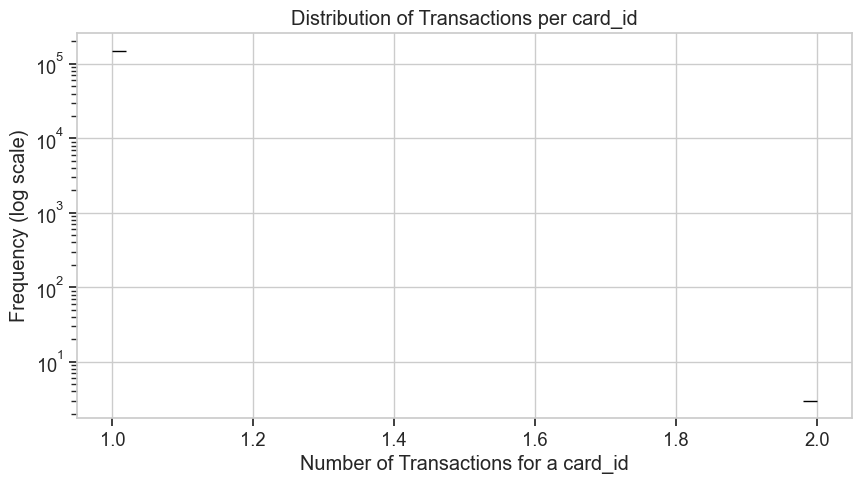

  Mean transactions per card_id: 1.00
  Median transactions per card_id: 1.00
  Max transactions for a single card_id: 2

  Number of unique card_ids associated with fraud: 3970
  Number of unique card_ids associated with non-fraud: 146027
  Number of card_ids associated with BOTH fraud and non-fraud: 0


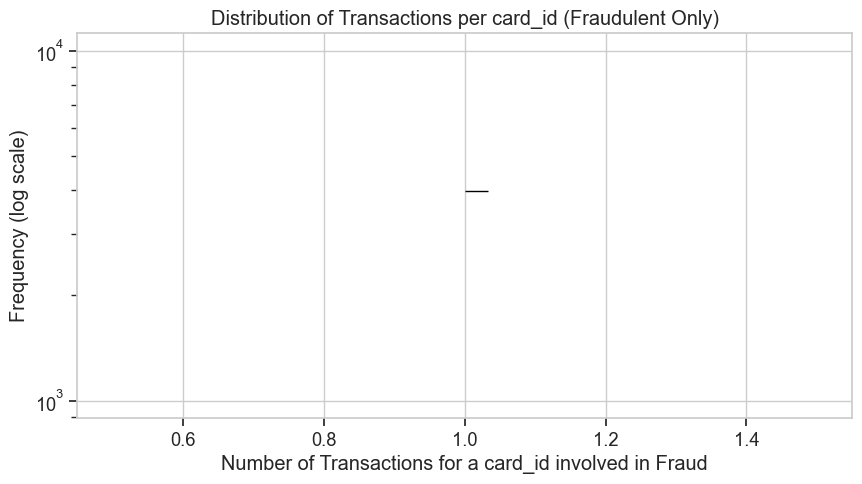

In [ ]:
#  Selectivity Analysis (Example for card_id) 
if 'card_id' in created_entity_ids and config.TARGET_COL in df_eda.columns:
    print("\nAnalyzing 'card_id' Selectivity...")
    # How many transactions per card_id?
    card_counts = df_eda['card_id'].value_counts()
    plt.figure(figsize=(10, 5))
    sns.histplot(card_counts, bins=50, log_scale=(False, True)) # Log scale for y-axis
    plt.title('Distribution of Transactions per card_id')
    plt.xlabel('Number of Transactions for a card_id')
    plt.ylabel('Frequency (log scale)')
    plt.show()
    print(f"  Mean transactions per card_id: {card_counts.mean():.2f}")
    print(f"  Median transactions per card_id: {card_counts.median():.2f}")
    print(f"  Max transactions for a single card_id: {card_counts.max()}")

    # Do fraudulent transactions share card_ids?
    fraud_card_counts = df_eda[df_eda[config.TARGET_COL] == 1]['card_id'].value_counts()
    nonfraud_card_counts = df_eda[df_eda[config.TARGET_COL] == 0]['card_id'].value_counts()

    print(f"\n  Number of unique card_ids associated with fraud: {len(fraud_card_counts)}")
    print(f"  Number of unique card_ids associated with non-fraud: {len(nonfraud_card_counts)}")
    common_cards = set(fraud_card_counts.index) & set(nonfraud_card_counts.index)
    print(f"  Number of card_ids associated with BOTH fraud and non-fraud: {len(common_cards)}")

    # Plot distribution of # transactions for cards involved in fraud
    if len(fraud_card_counts) > 0:
        plt.figure(figsize=(10, 5))
        sns.histplot(fraud_card_counts, bins=30, log_scale=(False, True))
        plt.title('Distribution of Transactions per card_id (Fraudulent Only)')
        plt.xlabel('Number of Transactions for a card_id involved in Fraud')
        plt.ylabel('Frequency (log scale)')
        plt.show()
else:
    print("Skipping selectivity analysis: 'card_id' or target column not available.")

**Interpretation:**
*   **Cardinality:** High cardinality for engineered IDs confirms they create many distinct nodes.
*   **Avg Group Size / Selectivity:** A low average group size means IDs are quite unique. A higher average group size (like for `card_id`) indicates that multiple transactions share the same ID, which is exactly what allows the GNN to pass messages between related transactions via these entity nodes.
*   **Fraud Overlap:** The number of IDs associated with both fraud and non-fraud is interesting. If many IDs see both types of transactions, it suggests these entity nodes could be valuable hubs for propagating fraud risk information.

## 7. Initial Concept Drift Check

We reuse the plotting logic from the dedicated drift analysis notebook to get an initial sense of data stability over time for the target and key features (including some entity ID source columns).


Analyzing drift for target variable: 'isFraud'


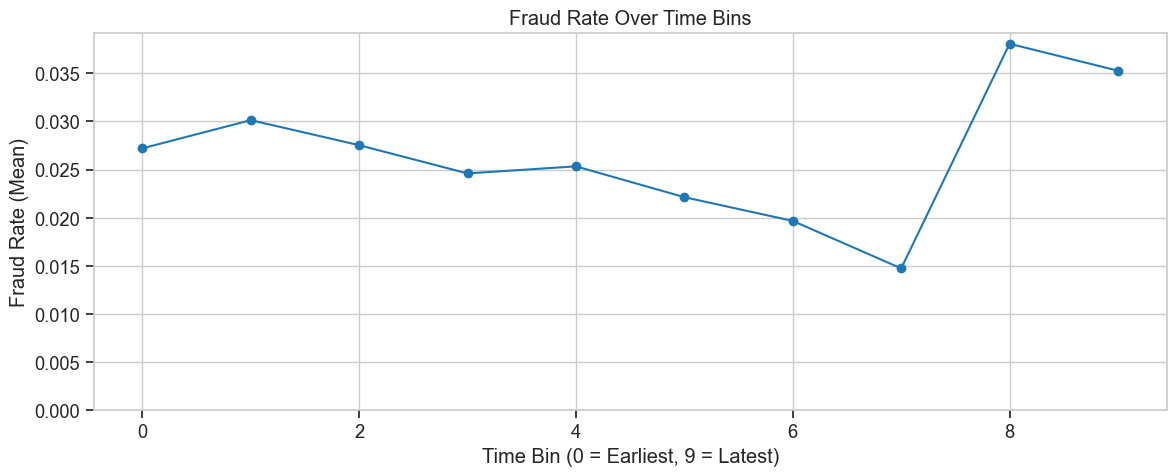


Analyzing drift for numerical features: ['TransactionAmt', 'dist1', 'C1', 'C2', 'D2', 'D3', 'id_01', 'id_02', 'V1', 'V3']


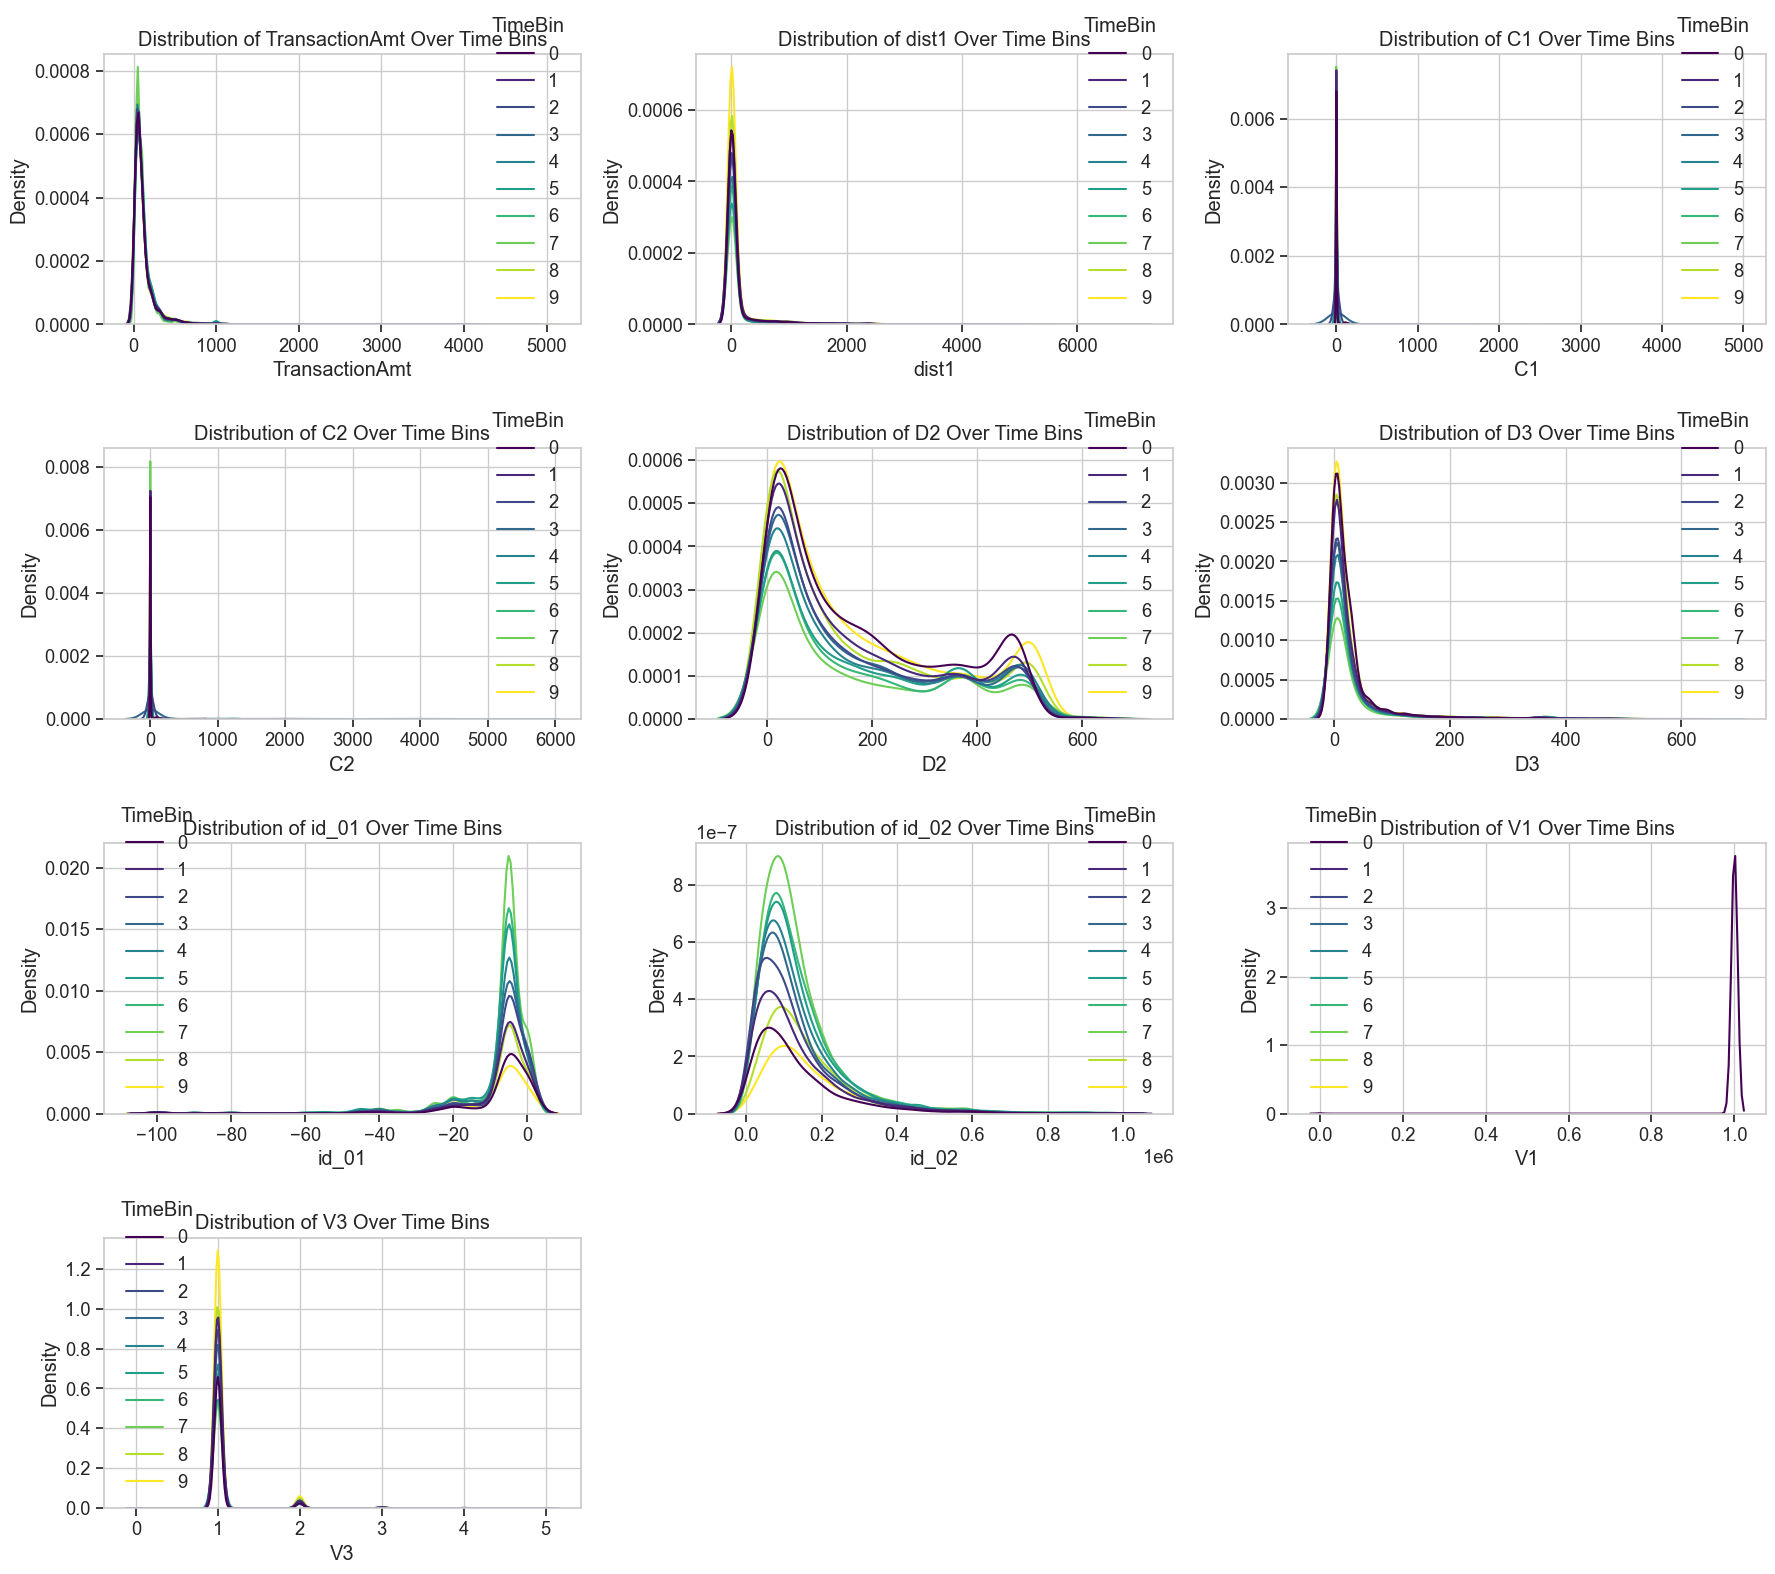


Analyzing drift for categorical features: ['ProductCD', 'id_13', 'id_14', 'M1', 'M4', 'id_15', 'id_34']


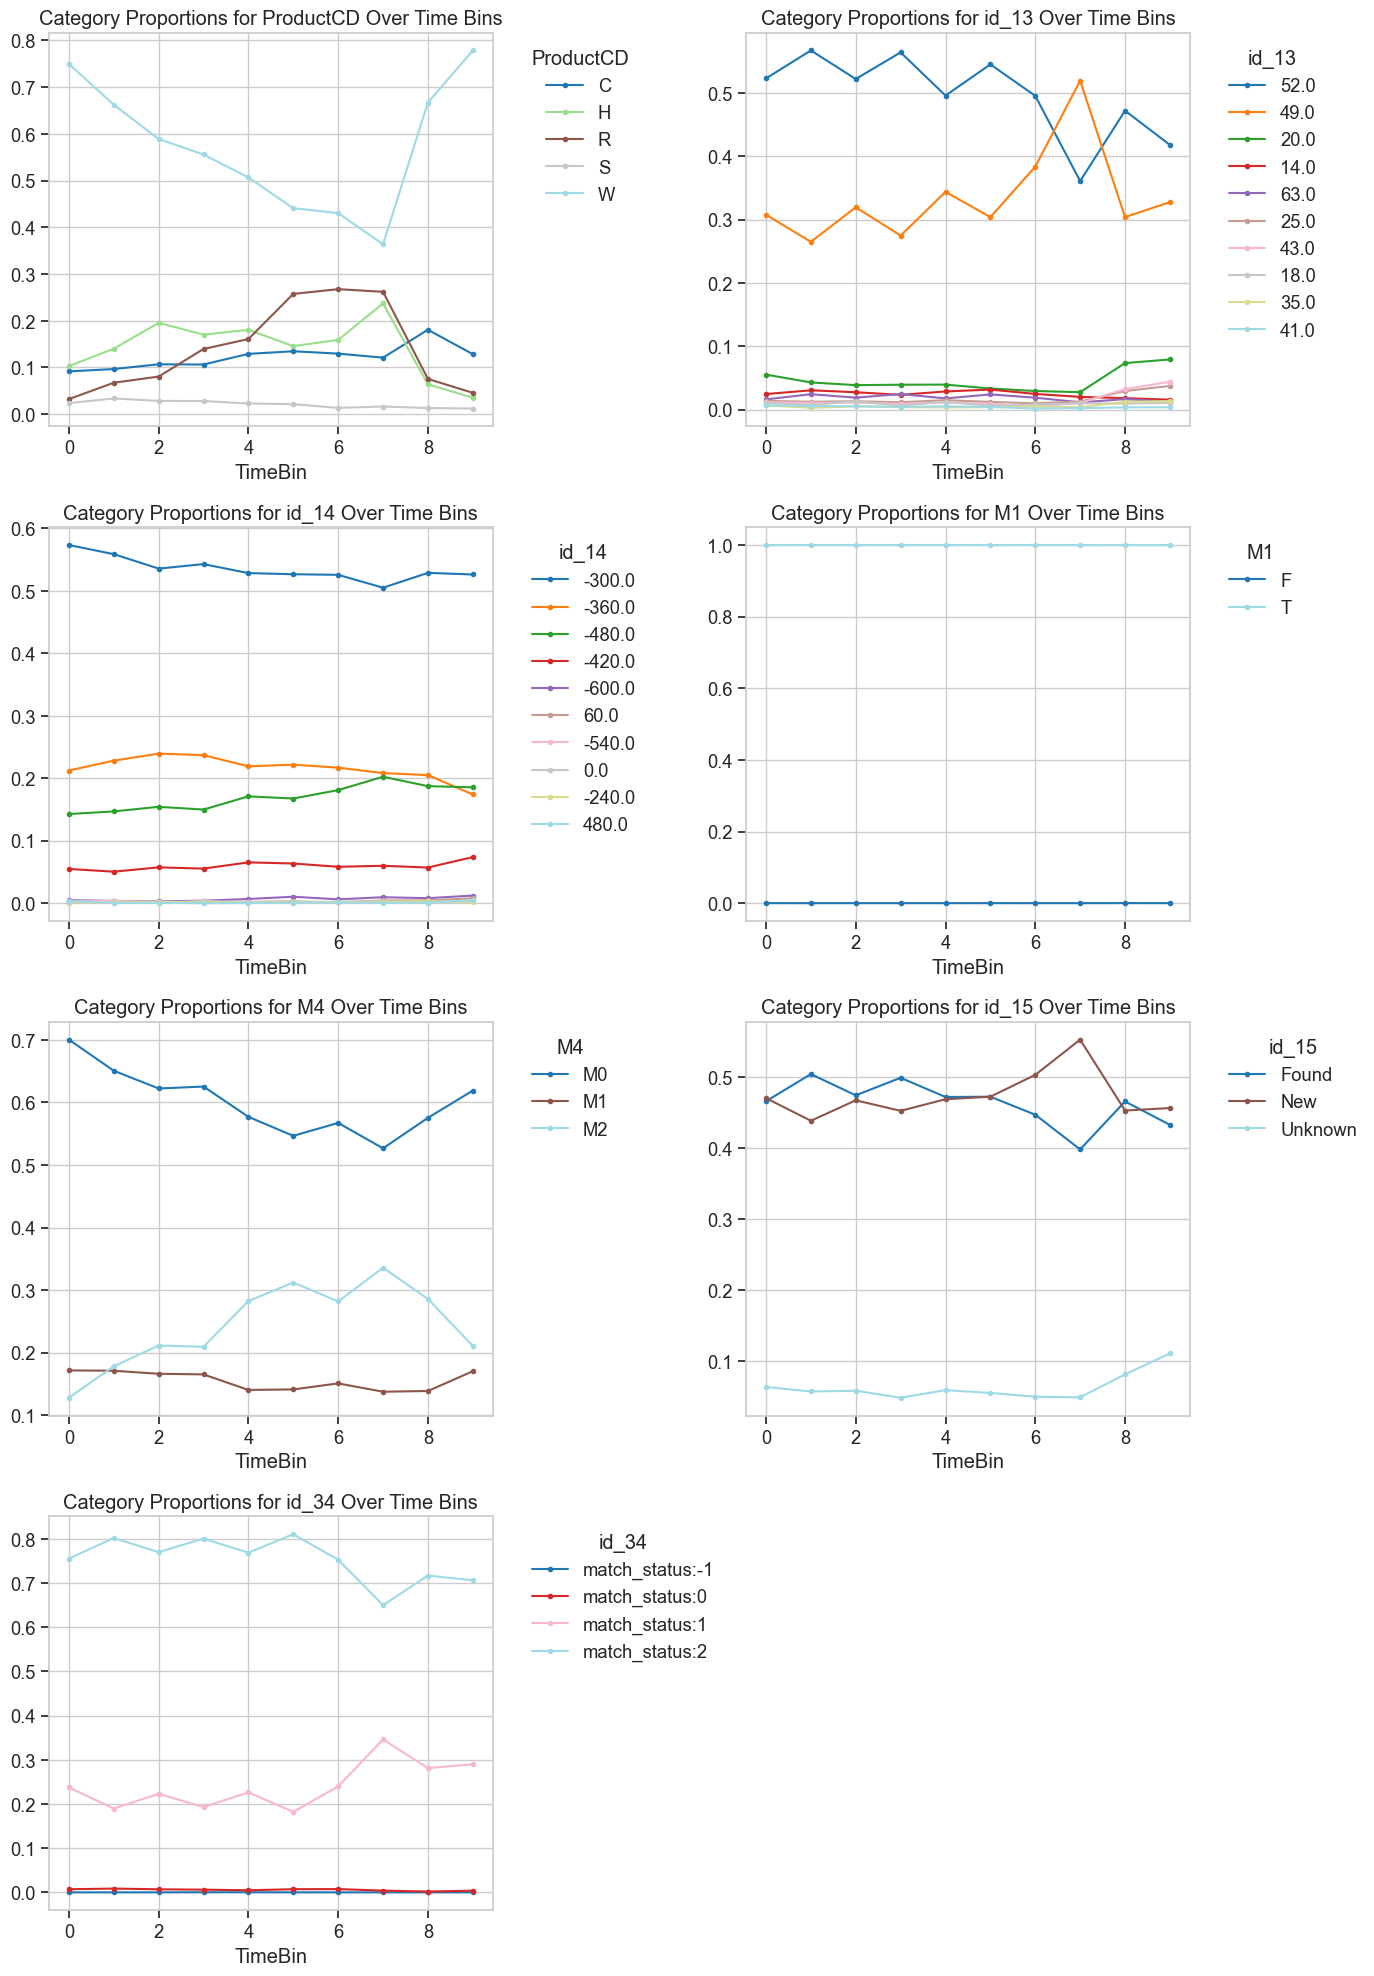

In [ ]:
#  Target Drift  
if config.TARGET_COL in df_eda.columns and 'TimeBin' in df_eda.columns:
    print(f"\nAnalyzing drift for target variable: '{config.TARGET_COL}'")
    fraud_rate_over_time = df_eda.groupby('TimeBin')[config.TARGET_COL].mean()
    plt.figure(figsize=(12, 5))
    fraud_rate_over_time.plot(marker='o', linestyle='-')
    plt.title('Fraud Rate Over Time Bins')
    plt.xlabel(f'Time Bin (0 = Earliest, {N_TIME_BINS-1} = Latest)')
    plt.ylabel('Fraud Rate (Mean)')
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"Cannot analyze target drift: Target column '{config.TARGET_COL}' or 'TimeBin' column missing.")

#  Numerical Feature Drift --- 
if 'TimeBin' in df_eda.columns:
    print(f"\nAnalyzing drift for numerical features: {config.KEY_NUM_FEATURES}")
    numerical_features_present = [f for f in config.KEY_NUM_FEATURES if f in df_eda.columns]
    if numerical_features_present:
        n_num_features = len(numerical_features_present)
        n_cols_plot = 3
        n_rows_plot = (n_num_features + n_cols_plot - 1) // n_cols_plot
        fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(n_cols_plot * 6, n_rows_plot * 4))
        axes = axes.flatten()
        for i, feature in enumerate(numerical_features_present):
            ax = axes[i]
            sns.kdeplot(data=df_eda, x=feature, hue='TimeBin', palette='viridis', ax=ax, warn_singular=False)
            ax.set_title(f'Distribution of {feature} Over Time Bins')
        for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()
    else:
        print("No key numerical features found.")
else:
    print("Cannot analyze numerical feature drift: 'TimeBin' column missing.")

#  Categorical Feature Drift  
if 'TimeBin' in df_eda.columns:
    print(f"\nAnalyzing drift for categorical features: {config.KEY_CAT_FEATURES}")
    categorical_features_present = [f for f in config.KEY_CAT_FEATURES if f in df_eda.columns]
    if categorical_features_present:
        n_cat_features = len(categorical_features_present)
        n_cols_plot = 2
        n_rows_plot = (n_cat_features + n_cols_plot - 1) // n_cols_plot
        fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(n_cols_plot * 7, n_rows_plot * 5))
        axes = axes.flatten()
        for i, feature in enumerate(categorical_features_present):
            ax = axes[i]
            proportions = df_eda.groupby('TimeBin')[feature].value_counts(normalize=True).unstack(fill_value=0)
            max_cats_to_show = 10
            if proportions.shape[1] > max_cats_to_show:
                top_cats = df_eda[feature].value_counts().nlargest(max_cats_to_show).index
                proportions = proportions[top_cats]
            proportions.plot(kind='line', marker='.', ax=ax, colormap='tab20')
            ax.set_title(f'Category Proportions for {feature} Over Time Bins')
            ax.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
        for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()
    else:
        print("No key categorical features found.")
else:
    print("Cannot analyze categorical feature drift: 'TimeBin' column missing.")

**Interpretation:** These plots provide an early warning about potential concept drift. Significant changes in the target rate or feature distributions over time suggest that models trained on earlier data may struggle to generalize to later data, necessitating time-aware validation and potentially more robust modeling approaches.

## 8. Conclusions and Next Steps

*   **Data Overview:** The dataset is large, contains significant missing values (especially in identity-related columns), and exhibits high cardinality in potential entity identifiers.
*   **Target Imbalance:** The target variable (`isFraud`) is highly imbalanced, requiring careful handling during modeling and evaluation.
*   **Entity ID Suitability:** Columns like `card1-6`, `addr1/2`, `DeviceInfo`, etc., have high cardinality and significant missingness. Engineered IDs (like `card_id`, `device_profile_id`) combine these but inherit the missing data challenge. However, IDs like `card_id` group multiple transactions, including both fraud and non-fraud, suggesting they could be useful nodes in a GNN for propagating information.
*   **Concept Drift:** **Strong evidence of concept drift** was observed in the target variable (fraud rate) and several key numerical and categorical features. Distributions and proportions change noticeably over time.
*   **External EDA:** Remember that detailed analysis of `id_xx` and `Vxxx` columns is omitted here but available in public resources (e.g., Kaggle kernels).

**Next Steps:**
1.  **Preprocessing:** Implement robust handling for missing values (imputation) and categorical features (encoding suitable for XGBoost and GNN embeddings).
2.  **Splitting:** Use a strict time-based split for train/validation/test sets to simulate real-world prediction.
3.  **Modeling:**
    *   Train baseline models (e.g., XGBoost) on processed tabular data.
    *   Construct the heterogeneous graph using the engineered entity IDs.
    *   Train GNN models (Hetero/Homo, different layers) on the graph data.
4.  **Evaluation:** Compare model performance using appropriate metrics (AUC, Average Precision) on the time-ordered test set.
5.  **Analysis:** Pay close attention to the validation vs. test performance gap, likely influenced by the observed concept drift.